# Extracting both the pKa and buridness data

In the following example we will be using TrIPP to determine the p*K*<sub>a</sub> values of the hen egg-white lysozyme (PDB ID: 1AKI). Three replicas have been run (MD1, MD2, and MD3). The files can be found in the tutorial/files folder and contain a PDB file of the minimised structure of the lysozyme and three replicas of the 300 ns trajectory sampled every 100 ps. The files contain only the protein. 

#### The `Trajectory` class 

The main class of TrIPP is the `Trajectory`. It contains the iterator that is able to iterate through the trajectory and extract p*K*<sub>a</sub> values using PROPKA3. The `Trajectory` class requires three arguments: 

- `trajectory_file`: `str`. The path of the file containing the trajectory. The same formats permited by MDAnalysis can be used. 

- `topology_file`: `str`. The path of the file containing the topology. The same formats allowed by MDAnalysis can be used. 

- `cpu_core_number`: `int`, `default=-1`. The number of cpu cores used for the calculation. If cpu_core_number=-1, all available cores are used. 

The `Trajectory` class contains a single method called `run`, which runs the iterator. The `run` method takes the following arguments: 

- `output_file`: `str`. The path of the output CSV file. 

- `extract_surface_data`: `bool`. If `True` both data on buridness and p*K*<sub>a</sub> will be extracted. If `False` only p*K*<sub>a</sub> data will be extracted. 

- `chain`: `str`,`default='A'`. Chain ID of target protein. If no chain ID is found in the `topology_file`, it is set to 'A'. 

- `mutation`: `int` or `list` of `int`, `default=None`. Allows for the *pseudomutation* of residues to alanine. The residue number or list of residue numbers is provided and TrIPP is run on the trajectory with the side chains of the selected residues removed and the residues treated as alanine. By comparing the *pseudomutated* trajectory to the unchanged, it is possible to understand the coontributions of the *pseudomutated* residues to the p*K*<sub>a</sub> of interacting residues. 

- `disulphide_bond_detection`: `bool`, `default=True`. If `True` detects all disulphide bonds present in the topology file and does not provide p*K*<sub>a</sub> values for them. 


Running the calculation produces a CSV file for each trajectory containing the p*K*<sub>a</sub> values (named 'output_file'_pka.csv) and one containing the buridness data (named 'output_file'_surf.csv), where each row corresponds to a timestep and each column to a residue. 

In [2]:
from tripp import Trajectory

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output_answer' 

topology_file = f'{file_directory}/1AKI_clean_min_cg_pbc_p.pdb' #topology, can be any format readable by MDAnalysis

for md in range(1,4): 
    trajectory_file = f'{file_directory}/1AKI_clean_eq_md{md}_T300_300ns_p_fit_skip100.xtc' #trajectory, can be any format readable by MDAnalysis
    TrIPP_Traj = Trajectory(trajectory_file=trajectory_file, 
                            topology_file=topology_file, 
                            cpu_core_number=-1) #Setting the argument cpu_number to -1 allows for the use of all available CPUs 
    
    TrIPP_Traj.run(output_file = f'{output_directory}/1AKI_clean_md{md}', 
                   extract_surface_data=True, #If this is set to False, only pKa data will be extracted, else both pKa and buridness data will be extracted 
                   chain='A', 
                   mutation=None, 
                   disulphide_bond_detection=True) #Automatically detects disulphide bonds and removes the cysteines from pKa calculation 

Your topology file contains no chain identity. Will add chain A for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.


It is often the case that the deviation of the p*K*<sub>a</sub> value of a residue in a protein from its model value in solution is important. It is affected by interactions with the environments (electrostatic, hydrogen bonding, apolar etc). TrIPP offers a function to determine the deviation for every residue compared to its model value during the trajectory. 

After calculating the p*K*<sub>a</sub> values of the protein residues using the `Trajectory.run()` method, it is possible to use the `process.calculate_difference_to_model()` function to calculate the difference to the model value for each residue. It takes a sinlge input: 

- `output_file`: `str`, must be the same `output_file` used in the `Trajectory.run()` method. 

This function produces a CSV file for each trajectory in the same directory as the original p*K*<sub>a</sub> file named 'output_file'_difference_to_model.csv. 

In [3]:
from tripp.process import calculate_difference_to_model 

output_directory = 'tutorial/output_answer' 

for md in range(1,4): 
    calculate_difference_to_model(output_file=f'{output_directory}/1AKI_clean_md{md}') 

Once the p*K*<sub>a</sub> values and differences to model values are calculated for the trajectory, their distribution can be visualised. This allows us to determine, which residues are more likely to change protonation state and diverge the most from model values. 

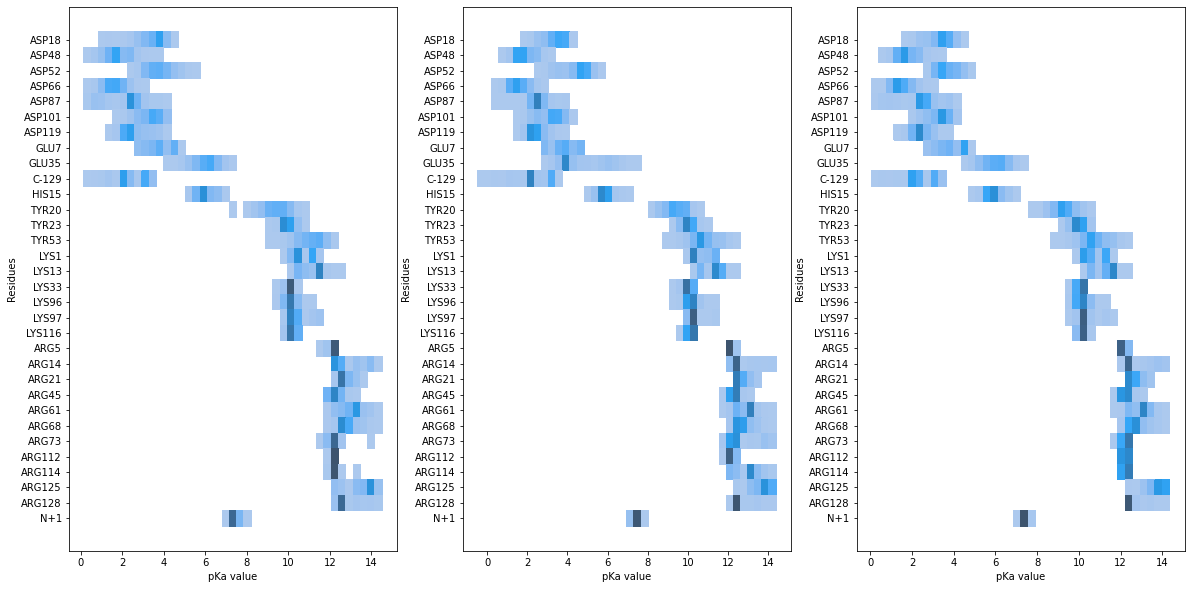

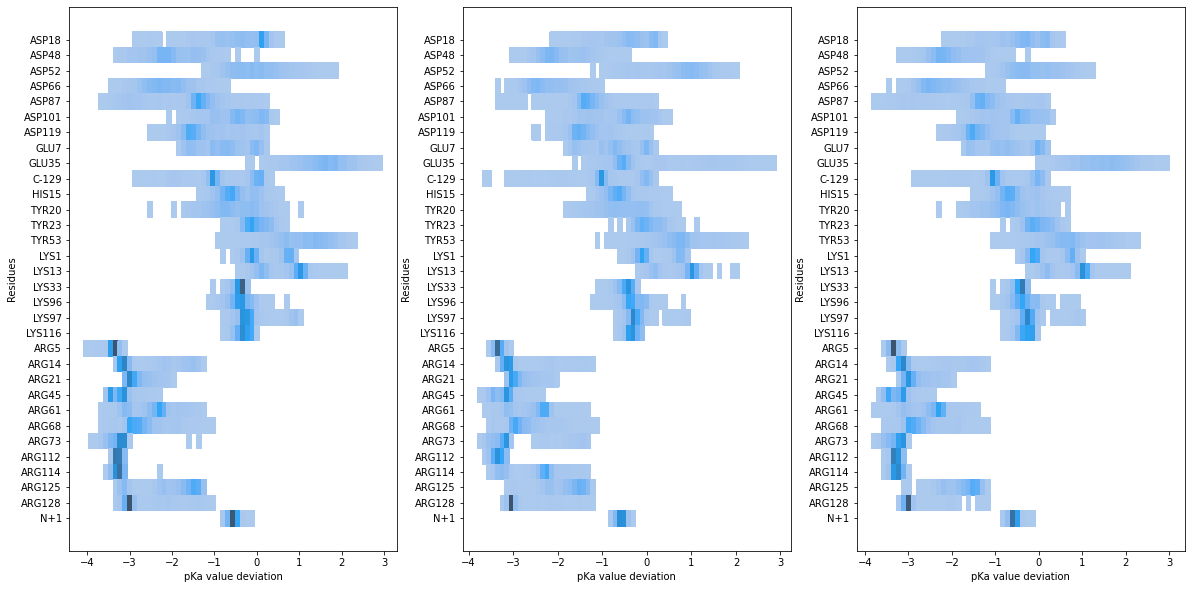

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

fig, ax = plt.subplots(1,3, figsize=(20, 10)) 

#Plot histogram showing the pKa values 
for md in range(1,4): 
    df_md = pd.read_csv(f'{output_directory}/1AKI_clean_md{md}_pka.csv') 
    df_melt = df_md.melt(id_vars='Time [ps]', var_name='Residues', value_name='pKa value') 
    sns.histplot(data=df_melt, x='pKa value', y='Residues', ax=ax[md-1]) 

fig, ax = plt.subplots(1,3, figsize=(20, 10)) 

#Plot histogram showing the deviation from the model pKa values 
for md in range(1,4): 
    df_md = pd.read_csv(f'{output_directory}/1AKI_clean_md{md}_difference_to_model.csv') 
    df_melt = df_md.melt(id_vars='Time [ps]', var_name='Residues', value_name='pKa value deviation') 
    sns.histplot(data=df_melt, x='pKa value deviation', y='Residues', ax=ax[md-1]) 

The above figure shows the distribution of the p*K*<sub>a</sub> value deviation for the three replicas. While larger deviations are present for arginine residues, the p*K*<sub>a</sub> values for these residues is still >12 making it unable to change protonation state at physiological conditions. 

The acidic residues ASP52 and GLU35 are of particular interest since they show an upshift of their p*K*<sub>a</sub> values. The model p*K*<sub>a</sub> values for aspartate and glutamate residues are 3.8 and 4.5, respectively. An increase of their p*K*<sub>a</sub>, due to their location in the protein, would allow for their protonation. Furthermore, these two residues are involved in the catalytic site of the henn egg-white lysozyme and are in proximity to one another. 

Visualising the p*K*<sub>a</sub> values of the two residues allows us to see the relationship between the two values. 

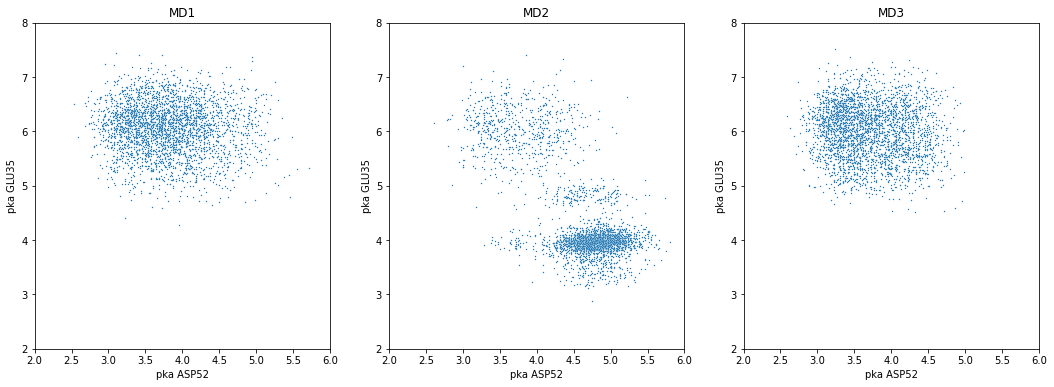

In [6]:
fig, ax = plt.subplots(1,3, figsize=(18,6)) 

for md in range(1,4): 
    df_md = pd.read_csv(f'{output_directory}/1AKI_clean_md{md}_pka.csv') 
    sns.scatterplot(data=df_md, x='ASP52', y='GLU35', ax=ax[md-1], s=2) 
    ax[md-1].set_xlim(2,6) 
    ax[md-1].set_ylim(2,8) 
    ax[md-1].set_xlabel('pka ASP52') 
    ax[md-1].set_ylabel('pka GLU35') 
    ax[md-1].set_title(f'MD{md}') 

The scatterplot of the p*K*<sub>a</sub> values of GLU35 and ASP52 shows two distinct populations of points. In MD1 and MD3 the p*K*<sub>a</sub> of GLU35 are higher compared to those of ASP52. In MD2 the same relationship is only observed for a subset of frames. In the rest of the MD2 frames the relationship seems to be inverted. 

# Clustering trajectories based on p*K*<sub>a</sub> values 

The second class of TrIPP is the `Clustering` class. It allows for the clustering of trajectory frames using the p*K*<sub>a</sub> values of selected residues alongside charge center distances (if selected). 

The `Clustering` takes the following arguments: 

- `trajectory_file`: `str` or `dict`. When `str`, it is the path of the file containing the trajectory. The same formats permited by MDAnalysis can be used. When `dict`, the clustering is done using multiple trajectories specified in a dictionary, where the name of each trajectory is used as a key and the path as an object: {'MD1' : 'file1', 'MD2' : 'file2', ...}. The same topology file is used for all trajectories. 

- `topology_file`: `str`. Path to the topology file. The same formats allowed by MDAnalysis can be used. 

- `pka_file`: `str` or `list`. When `str`, it is the path of the CSV file containing the p*K*<sub>a</sub> values generated by the `Trajectory` class using the same trajectory file and topology file selected for the clustering. When `list`, it is a list of paths of the CSV files corresponding to the dictionary selected for `trajectory_file`. When selecting a list of files for the `pka_file` argument the order of the files needs to be the same as in the `trajectory_file` dictionary. 

- `residues`: `list`. List of residues for which the clustering will be done. The residues have a p*K*<sub>a</sub> value assigned to them by PROPKA. 

- `log_file`: `str`. File name for log file 

- `include_distances`: `bool`, `default=True`. If `True`, the relative positions (as distances between the charge centers) are used as additional features for the clustering alongside the p*K*<sub>a</sub> values. 

- `dimensionality_reduction`: `bool`, `default=False`. If `True`, dimensionality reduction is performed on the generated data (p*K*<sub>a</sub> values and if selected charge center distances) using PCA. The number of components is selected that described >=90% of the cummulative variance and the clustering is done on those components. 

The `Clustering` contains three methods corresponding to three different clustering algorithms: `kmedoids`, `gromos`, and `dbscan`. The choice of clustering algorithm depends on the data the clustering is done on. In this case, we will be using the `kmedoids` method. It takes the following arguments: 

- `automatic`: `bool`, `default=False`. If `True` the clustering is run using various cluster numbers (defined by `max_clusters`). The silhouette score is determined at each iteration and the best number of clusters is chosen based on the highest silhouette score. 

- `n_clusters`: `int`, `default=8`. Number of clusters used for the clustering. Ignored if `automatic=True`. 

- `metric`, `method`, `init`, `max_iter`, `random_state` as found in [sklearn_extra.cluster.KMedoids](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html). 

- `max_clusters`: `int`, `default=20`. Max number of clusters to use when `automatic=True`. 

In our example, we will initially cluster all three trajectories and settting `automatic=True`. The clustering will generate PDB structures corresponding to the cluster centroid. 

In [3]:
from tripp import Clustering 

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output_answer' 

topology_file = f'{file_directory}/1AKI_clean_min_cg_pbc_p.pdb' 

trajectory_files = {'MD1' : f'{file_directory}/1AKI_clean_eq_md1_T300_300ns_p_fit_skip100.xtc', 
                    'MD2' : f'{file_directory}/1AKI_clean_eq_md2_T300_300ns_p_fit_skip100.xtc', 
                    'MD3' : f'{file_directory}/1AKI_clean_eq_md3_T300_300ns_p_fit_skip100.xtc'} 

pka_files = [f'{output_directory}/1AKI_clean_md1_pka.csv', 
             f'{output_directory}/1AKI_clean_md2_pka.csv', 
             f'{output_directory}/1AKI_clean_md3_pka.csv'] 

TrIPP_Clust = Clustering(trajectory_file=trajectory_files, 
                         topology_file=topology_file, 
                         pka_file=pka_files, 
                         residues=[35, 52], 
                         log_file=f'{output_directory}/1AKI_clean_all_md', 
                         include_distances=False, 
                         dimensionality_reduction=False) 

TrIPP_Clust.kmedoids(automatic=True, 
                     max_clusters=20) 

Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Clustering with 2 clusters produces an average silhouette score of 0.6377.
Clustering with 3 clusters produces an average silhouette score of 0.3928.
Clustering with 4 clusters produces an average silhouette score of 0.3902.
Clustering with 5 clusters produces an average silhouette score of 0.3796.
Clustering with 6 clusters produces an average silhouette score of 0.3624.
Clustering with 7 clusters produces an average silhouette score of 0.3536.
Clustering with 8 clusters produces an average silhouette score of 0.3631.
Clustering with 9 clusters produces an average silhouette score of 0.3429.
Clustering with 10 clusters produces an average silhouette score of 0.3769.
Clustering with 11 clusters produ

The clustering produces a log file containing the clustering details (1AKI_clean_all_md_KMedoids.log), one PDB file for each cluster containing the cluster centroid structure (1AKI_clean_all_md_C0.pdb and 1AKI_clean_all_md_C1.pdb) and one CSV file containing the clustering data alongside the p*K*<sub>a</sub> values (1AKI_clean_all_md_cluster.csv). Visualising the clustering results allows use to determine the quality of the clustering.  

<AxesSubplot:xlabel='ASP52', ylabel='GLU35'>

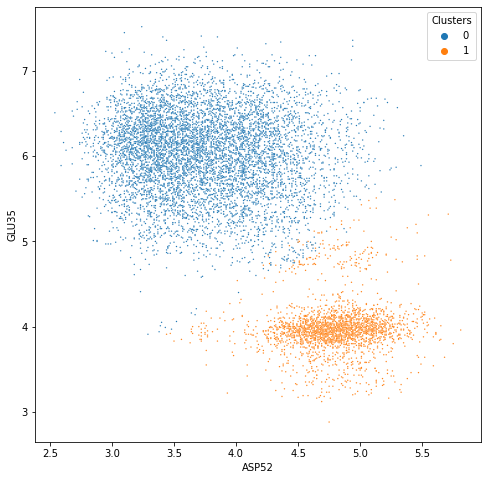

In [12]:
fig = plt.subplots(figsize=(8,8)) 

df_cluster = pd.read_csv(f'{output_directory}/1AKI_clean_all_md_cluster.csv') 
sns.scatterplot(data=df_cluster, x='ASP52', y='GLU35', s=2, hue='Clusters', palette='tab10') 

The cluster centroids of the two clusters indicate that the residue ARG114 might be interacting with GLU35, which might be affecting the glutamates p*K*<sub>a</sub> values. To further refine the clustering it can be rerun by taking into consideration the p*K*<sub>a</sub> values of ARG114. The distances between the charge centres of the residues can also be taken into consideration by setting `include_distances=True`. This will allow to take into consideration the relative position of the residues alogside the p*K*<sub>a</sub>. 

There are six features selcted for the clustering (three p*K*<sub>a</sub> values and three distances) for each frame. To counter the potential loss of clustering quality, dimensionality reduction can be used by setting `dimensionality_reduction=True`. When this argument is set to `True`, PCA is run on the dataset and the least amount of principal components that describe 90% of the cummulative variance are selected. The clustering is run on the data projected onto those PCs. 

Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Clustering with 2 clusters produces an average silhouette score of 0.6534.
Clustering with 3 clusters produces an average silhouette score of 0.5036.
Clustering with 4 clusters produces an average silhouette score of 0.4918.
Clustering with 5 clusters produces an average silhouette score of 0.452.
Clustering with 6 clusters produces an average silhouette score of 0.4305.
Clustering with 7 clusters produces an average silhouette score of 0.4178.
Clustering with 8 clusters produces an average silhouette score of 0.4125.
Clustering with 9 clusters produces an average silhouette score of 0.4204.
Clustering with 10 clusters produces an average silhouette score of 0.3452.
Clustering with 11 clusters produc

<AxesSubplot:xlabel='ASP52', ylabel='GLU35'>

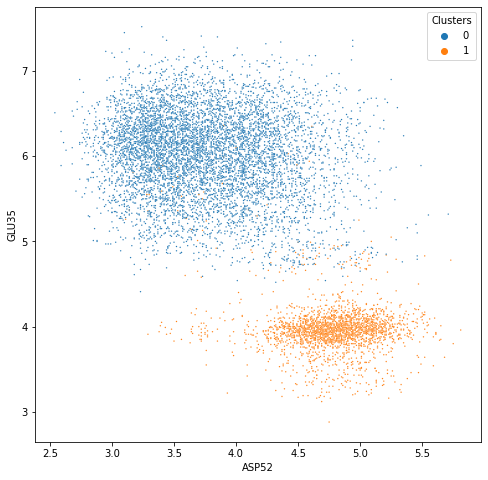

In [15]:
from tripp import Clustering 

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output_answer' 

topology_file = f'{file_directory}/1AKI_clean_min_cg_pbc_p.pdb' 

trajectory_files = {'MD1' : f'{file_directory}/1AKI_clean_eq_md1_T300_300ns_p_fit_skip100.xtc', 
                    'MD2' : f'{file_directory}/1AKI_clean_eq_md2_T300_300ns_p_fit_skip100.xtc', 
                    'MD3' : f'{file_directory}/1AKI_clean_eq_md3_T300_300ns_p_fit_skip100.xtc'} 

pka_files = [f'{output_directory}/1AKI_clean_md1_pka.csv', 
             f'{output_directory}/1AKI_clean_md2_pka.csv', 
             f'{output_directory}/1AKI_clean_md3_pka.csv'] 

TrIPP_Clust = Clustering(trajectory_file=trajectory_files, 
                         topology_file=topology_file, 
                         pka_file=pka_files, 
                         residues=[35, 52, 114], 
                         log_file=f'{output_directory}/1AKI_clean_all_md_35_52_114_include_distances', 
                         include_distances=True, 
                         dimensionality_reduction=True) 

TrIPP_Clust.kmedoids(automatic=True, 
                     max_clusters=20) 

fig = plt.figure(figsize=(8,8)) 

df_cluster = pd.read_csv(f'{output_directory}/1AKI_clean_all_md_35_52_114_include_distances_cluster.csv') 
sns.scatterplot(data=df_cluster, x='ASP52', y='GLU35', s=2, hue='Clusters', palette='tab10') 

The new cluster representatives show that in cluster 0 GLU35 is forming a salt bridge with ARG114 and in cluster 1 ASP35 is forming hydrogen bonds with ASN44. As a next step it would be interesting to understand the contibution of these interactions to the p*K*<sub>a</sub> during the trajeectory. To do this, TrIPP offers the _pseudomutation_ capability. 

# _Pseudomutations_ in TrIPP 

TrIPP offers a built-in way to understand the contribution of interactions to the p*K*<sub>a</sub> of a residue. The way TrIPP does this is by running the p*K*<sub>a</sub> iterator of the `Trajectory` class and setting the `mutation` argument to the residue of interest. This leads to TrIPP running the p*K*<sub>a</sub> calculations on the trajectory, however, with the residue of choice being changed to alanine. This does not affect the conformation of the trajectory in any way since no new MD simulations are run. It allows for the determination of the p*K*<sub>a</sub> of residues in teh absence of the functional group contributions of the selected residues. 

In our example, we will run three _pseudomutations_: One where ASN44 is mutated, one where ARG114 is mutated, and one where both are. 

In [17]:
from tripp import Trajectory 

file_directory = 'tutorial/files' 
output_directory = 'tutorial/output_answer' 

topology_file = f'{file_directory}/1AKI_clean_min_cg_pbc_p.pdb' 

for md in range(1,4): 
    for mutation in [44, 114, [44, 114]]: 
        trajectory_file = f'{file_directory}/1AKI_clean_eq_md{md}_T300_300ns_p_fit_skip100.xtc' 
        TrIPP_Traj = Trajectory(trajectory_file=trajectory_file, 
                                topology_file=topology_file, 
                                cpu_core_number=-1) 
        TrIPP_Traj.run(output_file=f'{output_directory}/1AKI_clean_md{md}', 
                       extract_surface_data=False, 
                       chain='A', 
                       mutation=mutation, 
                       disulphide_bond_detection=True) 

Your topology file contains no chain identity. Will add chain A for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no chain identity. Will add chain A for your whole system by default
Cysteines involved in disulphide bonds: CYS6, CYS30, CYS64, CYS76, CYS80, CYS94, CYS115, CYS127.
pKa will not be calculated for these cysteines.
Your topology file contains no c

Visualising the the p*K*<sub>a</sub> values of GLU35 and ASP52 for the different pseudomutations and trajectories allows us to see the contributions of ASN44 and ARG114. 

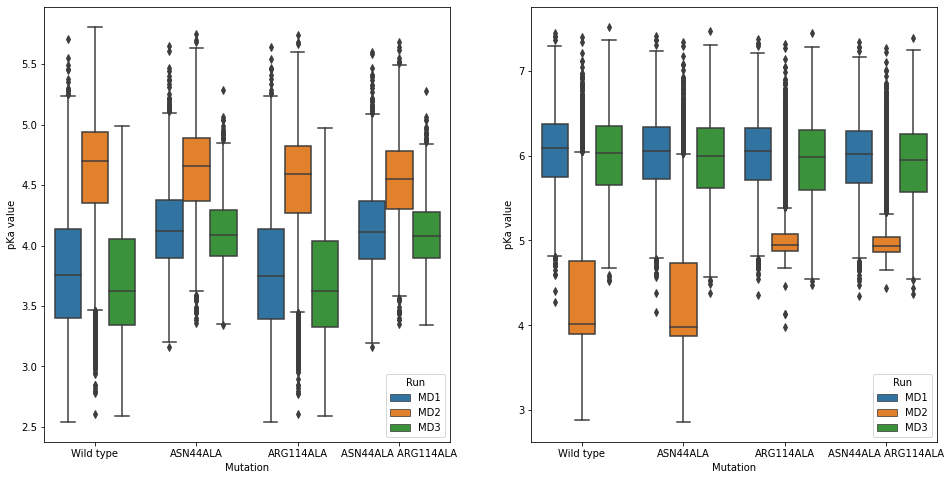

In [29]:
mutant_df_list = [] 
mutation_dict = {'Wild type' : '', 'ASN44ALA' : '_44', 'ARG114ALA' : '_114', 'ASN44ALA ARG114ALA' : '_44_114'} 
for md in range(1,4): 
    for index, mutation in enumerate(mutation_dict.keys()): 
        df = pd.read_csv(f'{output_directory}/1AKI_clean_md{md}{mutation_dict[mutation]}_pka.csv') 
        df = df[['Time [ps]', 'ASP52', 'GLU35']] 
        df_melt = df.melt(id_vars='Time [ps]', var_name='Residues', value_name='pKa value') 
        df_melt['Run'] = f'MD{md}' 
        df_melt['Mutation'] = mutation 
        mutant_df_list.append(df_melt) 

df_mutant = pd.concat(mutant_df_list) 

fig, ax = plt.subplots(1,2, figsize=(16,8)) 
for index, item in enumerate(['ASP52', 'GLU35']): 
    sns.boxplot(data=df_mutant[df_mutant['Residues']==item], x='Mutation', y='pKa value', hue='Run', ax=ax[index]) 

One can inspect the time evolution of the pKa and buridness of a specific residue, ie: ASP52

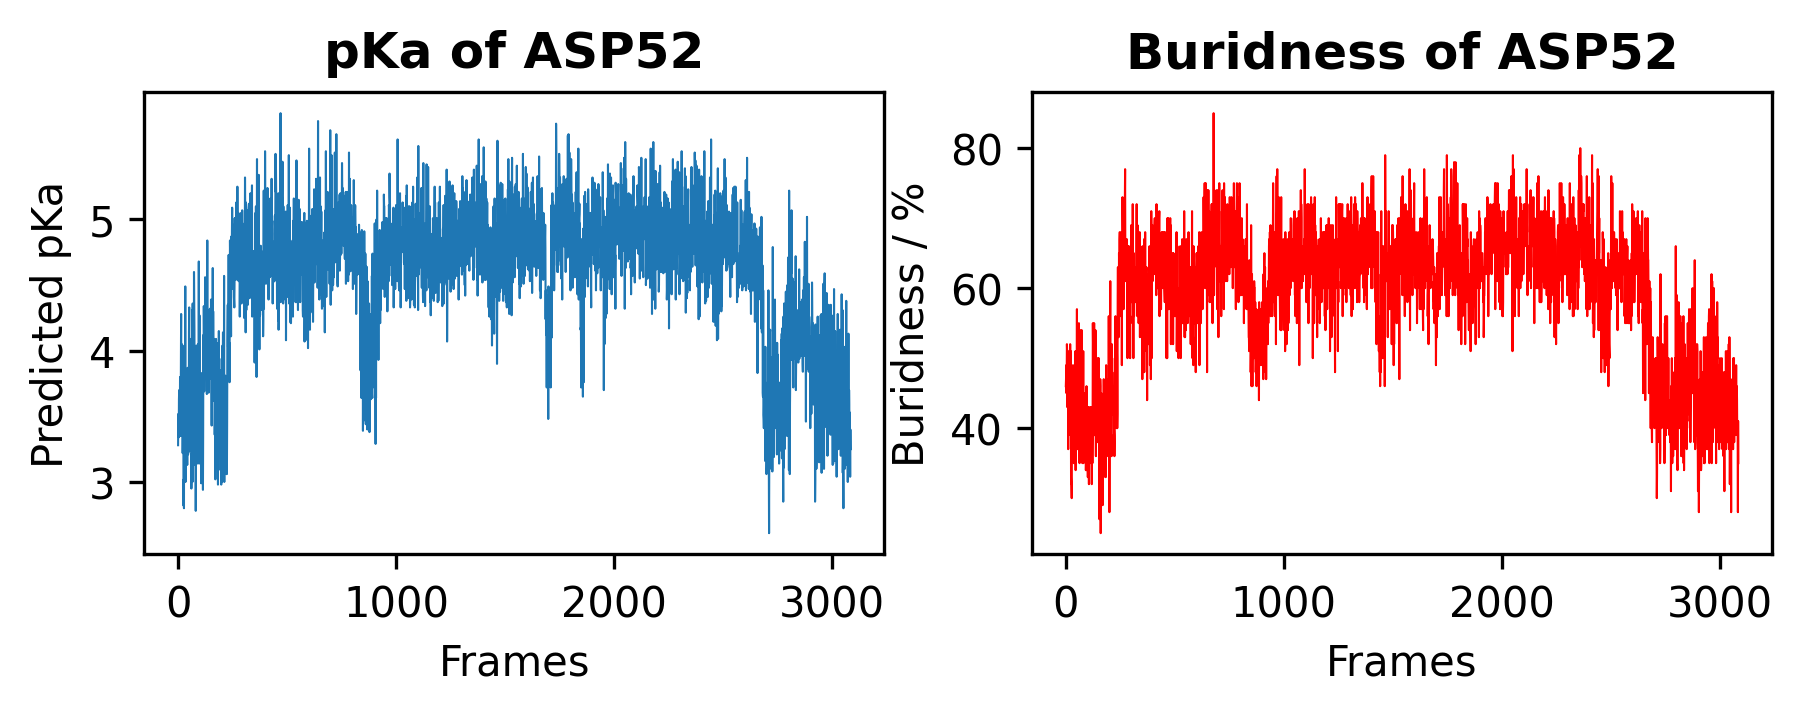

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(7,2),dpi=300)
df_pka = pd.read_csv('./1AKI_clean_md2_pka.csv')
df_pka['ASP52'].plot(ax=ax[0], lw=0.5)
ax[0].set_ylabel('Predicted pKa')
ax[0].set_xlabel('Frames')
ax[0].set_title('pKa of ASP52',fontweight="bold")
df_surf = pd.read_csv('./1AKI_clean_md2_surf.csv')
df_surf['ASP52'].plot(ax=ax[1],lw=0.5,color='red')
ax[1].set_ylabel('Buridness / %')
ax[1].set_xlabel('Frames')
ax[1].set_title('Buridness of ASP52',fontweight="bold")
plt.show()

# Pseudomutation on ASN44 and ARG114
Notice that both ASP52 and GLU35 had a higher pKa range than its normal pKa at pH 7.4. Visual inspection of the trajectory shows that ASN44 and ARG114 seem to be the main contriubution leading to the increase of their pKa, respectively. To confirm their contributions, a pseudomutation of the exisiting trajectory can be performed individually.

In [ ]:
tripp = Trajectory(trajectory_file=traj,
                              topology_file = pdb,
                              cpu_core_number=10)
#Pseudomutate ASN44 to confirm its contribution on ASP52
tripp.run(output_file='1AKI_clean_md2',
          extract_surface_data=True, #If this is set to False, only pKa data will be extracted, else both pKa and buridness data will be extracted
          chain='A',
          mutation=44)
#Pseudomutate ARG114 to confirm its contribution on GLU35
tripp.run(output_file='1AKI_clean_md2',
          extract_surface_data=True, #If this is set to False, only pKa data will be extracted, else both pKa and buridness data will be extracted
          chain='A',
          mutation=114)

Your topology file contains no chain identity. Will add chain A for your whole system by default


/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default


/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/b

Your topology file contains no chain identity. Will add chain A for your whole system by default


/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default
Your topology file contains no chain identity. Will add chain A for your whole system by default


/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/b

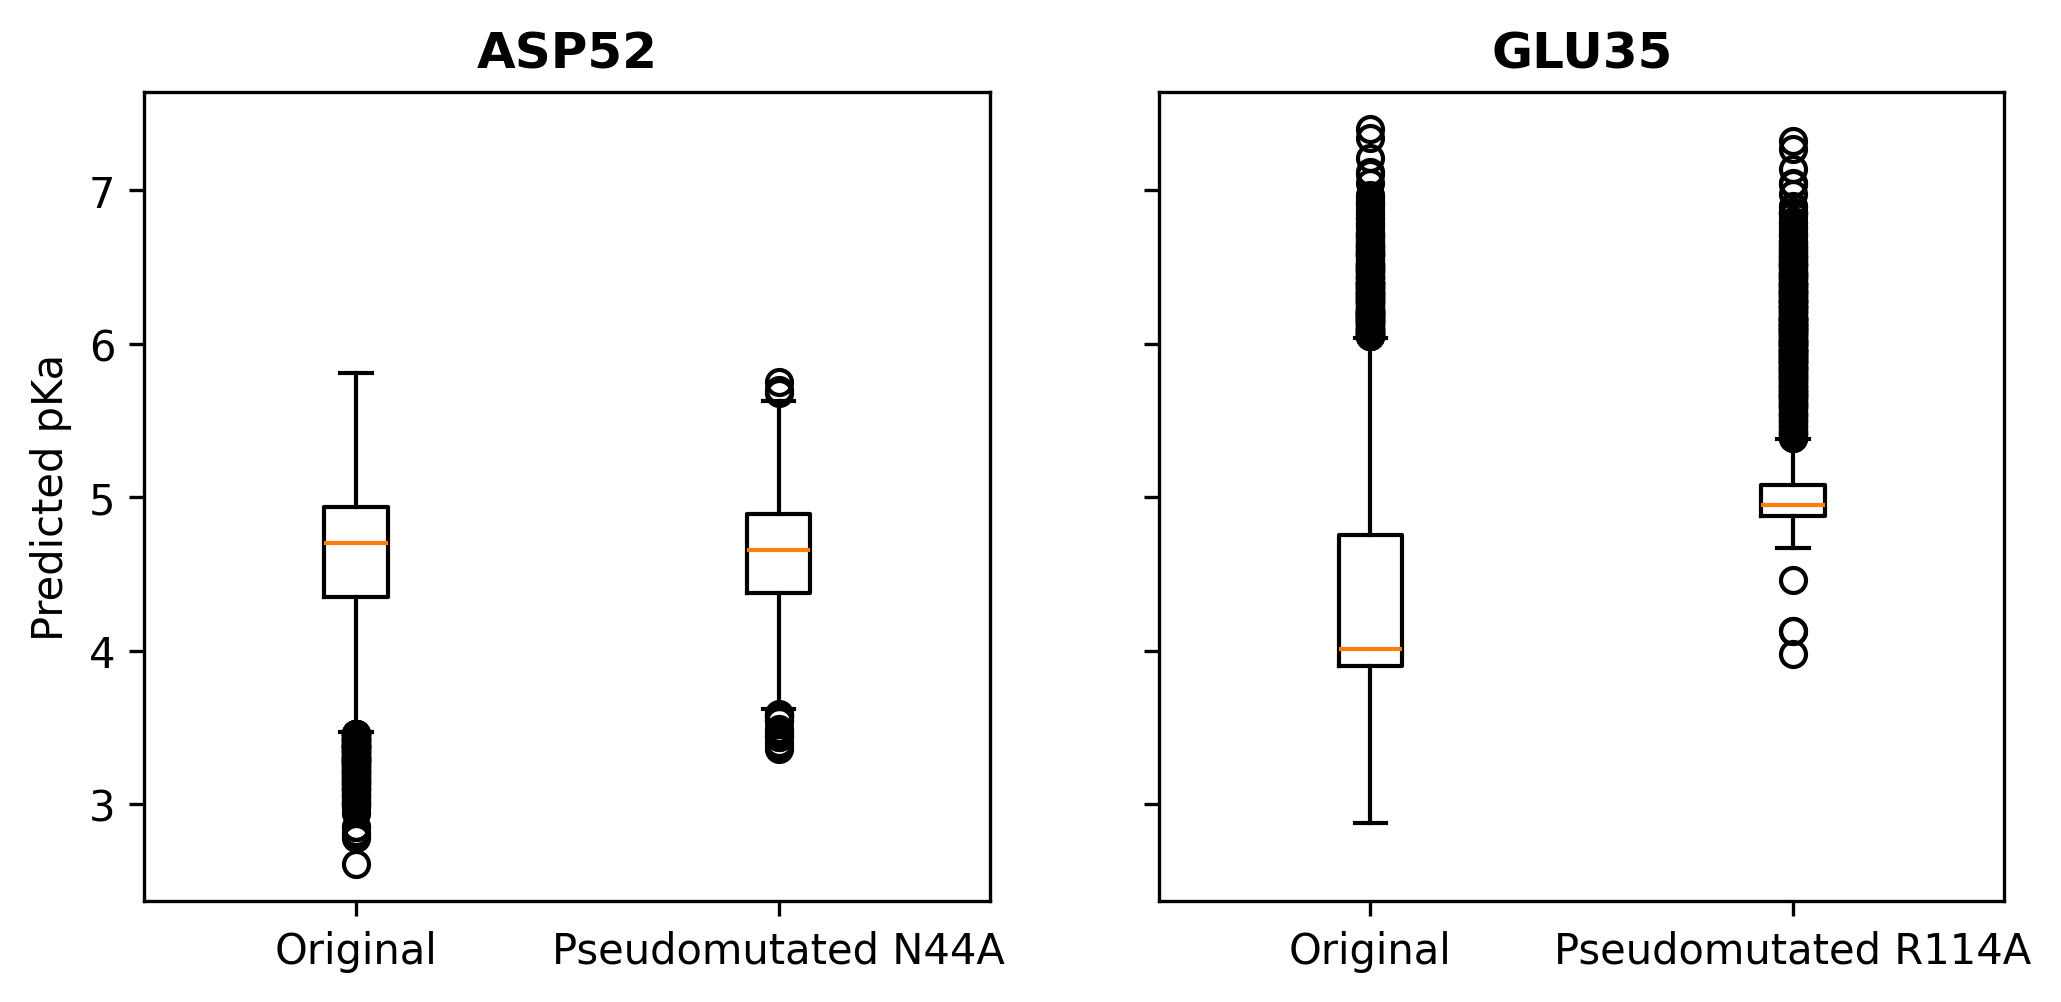

In [ ]:
csvs = ['1AKI_clean_md2_pka.csv','1AKI_clean_md2_44_pka.csv','1AKI_clean_md2_114_pka.csv']
targets = ['ASP52','GLU35']
ref_pka = [3.90,4.31] #CRC Handbook of Chemistry and Physics 95th Edition at 25 degrees celcius
fig,ax = plt.subplots(1,2,figsize=(8,3.5),sharey=True,dpi=300)
df_before = pd.read_csv(csvs[0])
df_N44A = pd.read_csv(csvs[1])
df_R114A = pd.read_csv(csvs[2])

ax[0].boxplot([df_before[targets[0]],df_N44A[targets[0]]])
ax[1].boxplot([df_before[targets[1]],df_R114A[targets[1]]])
ax[0].set_xticklabels(['Original','Pseudomutated N44A'])
ax[1].set_xticklabels(['Original','Pseudomutated R114A'])
ax[0].set_title(targets[0],fontweight="bold")
ax[1].set_title(targets[1],fontweight="bold")
ax[0].set_ylabel('Predicted pKa')
plt.show()

ASP52 form hydrogen bond with ASN44 which lowers the pKa of ASP52. However, conformational changes of the protein disrupted this hydrogen bond (ASP52:Side-ASN44:Side). This leads to an increase of pKa during when hydrogen bond is deformed. Pseudomutation of ASN44 to ALA44 reveals that it directly affect ASP52 pKa as the hydrogen bond can no longer form between ASP52 and ALA44.

Similarly, ARG114 directly affects the pKa of GLU35 which is confirmed by the pseudomutation of ARG114 to ALA114. The lost of hydrogen bond increases the pKa.

# Visualization

In [ ]:
from tripp import Visualization

Another function provided in TrIPP package is the visualization tool. It provides a quick way to analyse the mean pKa of residues.
The visualization class takes in two input parameters. One is the structure of the protein and the other one is the csv file of the pKa generated from running the Trajectroy class.

In [ ]:
original_visualization = Visualization(pdb,'./1AKI_clean_md2_pka.csv')

Two coloring method is provided in the function "color_pka()".
1. "mean" calculates the mean value of the residue pKa over the trajectory, and is assigned to the bfactor/tempfactor of the residue in the structure file.
2. "difference_to_model_value" calculates the mean value of the residue pKa over the trajectory. The mean value is then subtracted from the model pka value in solution as given by PROPKA.

In [ ]:
pymol_path = '/Applications/PyMOL.app/Contents/MacOS/MacPyMOL' #Make sure you specify where your pymol installation is 
original_visualization.color_pka(pymol_path,'1AKI_clean_md2_pka','mean',0,14,'red_white_blue')

/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1200: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


 PyMOL(TM) 3.0.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected OpenGL version 2.1. Shaders available.
 Tessellation shaders not available
 Detected GLSL version 1.20.
 OpenGL graphics engine:
  GL_VENDOR:   Apple
  GL_RENDERER: Apple M2 Pro
  GL_VERSION:  2.1 Metal - 83
 License Expiry date: 01-jul-2024
 Detected 12 CPU cores.  Enabled multithreaded rendering.


In [ ]:
original_visualization.color_pka(pymol_path,'1AKI_clean_md2_pka','difference_to_model_value',-5,5,'red_white_blue')

/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/Users/kafuman/bin/miniconda3/envs/TrIPP/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1200: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


 PyMOL(TM) 3.0.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected OpenGL version 2.1. Shaders available.
 Tessellation shaders not available
 Detected GLSL version 1.20.
 OpenGL graphics engine:
  GL_VENDOR:   Apple
  GL_RENDERER: Apple M2 Pro
  GL_VERSION:  2.1 Metal - 83
 License Expiry date: 01-jul-2024
 Detected 12 CPU cores.  Enabled multithreaded rendering.


User can visualize the corresponding PyMOL session (.pse) for quick analysis.